In [1]:
import pandas as pd
import numpy as np

In [2]:
import lsdb
from tape import Ensemble, ColumnMapper
import matplotlib.pyplot as plt
import dask
dask.config.set({'temporary_directory': '/data/epyc/users/fbcb/tmp'})

from dask.distributed import Client
client = Client(n_workers=10, threads_per_worker=10,
                memory_limit="60G")

client

/astro/users/fbcb/.conda/envs/lsdb_demo/lib/python3.10/contextlib.py:142: UserWarning: Creating scratch directories is taking a surprisingly long time. (2.01s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/astro/users/fbcb/.conda/envs/lsdb_demo/lib/python3.10/contextlib.py:142: UserWarning: Creating scratch directories is taking a surprisingly long time. (2.02s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/astro/users/fbcb/.conda/envs/lsdb_demo/lib/python3.10/contextlib.py:142: UserWarning: Creating scratch directories is taking a surprisingly long time. (2.02s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 100,Total memory: 558.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36254,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 100
Started: Just now,Total memory: 558.79 GiB
Comm: tcp://127.0.0.1:43141,Total threads: 10
Dashboard: http://127.0.0.1:41298/status,Memory: 55.88 GiB
Nanny: tcp://127.0.0.1:40680,


In [3]:
# Load from the small Ensemble
ens = Ensemble(client=client)
ens.from_ensemble("./ztf_small_ensemble")

In [4]:
len(ens.object)

892844

In [5]:
sec_to_day = 1 / (24 * 60 * 60)
max_dt_hc = 6 * 40 * sec_to_day

min_consec_obs = int((30 * 60) / 40)

In [6]:
# do the intervals using the already created masks and use ()

https://stackoverflow.com/questions/35091879/merge-two-arrays-vertically-to-array-of-tuples-using-numpy

In [7]:
def identify_hc_objects_band(mjd, band, flag, mag, magerr, band_name, 
                             max_dt = max_dt_hc, min_len = min_consec_obs):
    
    if (band.size > 0):
        
        arr_band_name = np.array([band_name])
        bands_obs = np.unique(band)
    
        if np.isin(arr_band_name, bands_obs, invert=True)[0]:
            return 0, 0, 0

        band_mask = ((band == band_name) & (flag == 0) & (magerr>0)  
                    & (~np.isnan(mjd)) & (~np.isnan(mag)) & (~np.isnan(magerr))) # remove nans!
    
        if np.sum(band_mask) == 0:
            return 0, 0, 0
    
        else:
            # sort time
            srt = mjd.argsort()
            mjd = mjd[srt]
            
            srt_mask = band_mask[srt]
            
            # select times of good obs in a specific band
            mjd_band = mjd[srt_mask]
            mag_band = mag[srt_mask]
            magerr_band = mag[srt_mask]
            
            # calculate the number of observations
            num_obs = len(mjd_band)
    
            if num_obs < min_len:
                return 0, 0, 0
    
            else:
                # calculate the difference in mjd for the same band
                dt = np.diff(mjd_band)
                len_dt = num_obs - 1
        
                # create an array of indexes of delta t
                idx_dt = np.indices((len_dt,))[0]
    
                # create a mask indicating if dt > max_dt
                above_max_dt = (dt > max_dt)
        
                # select indexes that satisfy dt > max_dt
                idx_mask = idx_dt[above_max_dt]
            
                # all observations are hc observations
                if (len(idx_mask) == 0):
                    mjd_start_hc = np.min(mjd_band)
                    mjd_end_hc = np.max(mjd_band)
                    
                    # range of mjd of hc observations
                    hc_mjd_range = np.array([mjd_start_hc, mjd_end_hc])
                    num_hc_obs = np.array([num_obs])
                    num_hc_int = 1
                    
                    return num_hc_int, hc_mjd_range, num_hc_obs
                   
                    
                else:
                    # hc observations at the beggining or at the end
                    idx_0 = idx_mask[0]
                    last_idx = idx_mask[-1]
                
                    first_obs_hc = (idx_0 >= min_len)
                    last_obs_hc = (len_dt - last_idx >= min_len)
                
                    # hc observations in the middle
                    idx_mask_diff = np.diff(idx_mask)
                    high_cadence_mask = (idx_mask_diff >= (min_len + 1))
                    center_obs_hc = (np.sum(high_cadence_mask) >= 1)
                    
                    if center_obs_hc:
                        idx_start_hc = idx_mask[:-1][high_cadence_mask] + 1
                        idx_end_hc = idx_start_hc + idx_mask_diff[high_cadence_mask] - 1
                        
                        # central range of mjd of hc observations
                        mjd_start_hc = mjd_band[idx_start_hc]
                        mjd_end_hc = mjd_band[idx_end_hc]
                        
                        # return the range of mjd and the number of observations
                        central_hc_range = np.c_[mjd_start_hc, mjd_end_hc]
                        len_central_hc = idx_mask_diff[high_cadence_mask] - 1
                    
                        if first_obs_hc:
                            mjd_1st_hc_start = np.min(mjd_band)
                            mjd_1st_hc_end = mjd_band[idx_0 - 1]
                            
                            # 1st hc observations
                            first_hc_range = [mjd_1st_hc_start, mjd_1st_hc_end]
                            len_first_hc = [idx_0] # because it starts with index 0
                            
                            # range of hc observations
                            first_and_central = np.append(first_hc_range, central_hc_range)
                            len_first_and_central_hc = np.append(len_first_hc, len_central_hc)
                            
                        
                            if last_obs_hc:
                                mjd_last_hc_start = mjd_band[last_idx + 1]
                                mjd_last_hc_end = mjd_band[-1]
                                
                                # last hc observation
                                last_hc_range = [mjd_last_hc_start, mjd_last_hc_end]
                                len_last_hc = [len(mjd_band) - (last_idx + 1)]
                            
                                # range of hc observations
                                hc_mjd_range = np.append(first_and_central, last_hc_range)
                                num_hc_obs = np.append(len_first_and_central_hc, len_last_hc)
                                num_hc_int = len(num_hc_obs)
                                
                                return num_hc_int, hc_mjd_range, num_hc_obs
                                
                    
                            else:
                                hc_mjd_range = first_and_central
                                num_hc_obs = len_first_and_central_hc
                                num_hc_int = len(num_hc_obs)
                                
                                return num_hc_int, hc_mjd_range, num_hc_obs

                        
                        elif last_obs_hc:
                            
                            mjd_last_hc_start = mjd_band[last_idx + 1]
                            mjd_last_hc_end = mjd_band[-1]
                            
                            # last range of hc observations
                            last_hc_range = [mjd_last_hc_start, mjd_last_hc_end]
                            len_last_hc = [len(mjd_band) - (last_idx + 1)]
                                
                            # total range of hc observations
                            hc_mjd_range = np.append(central_hc_range, last_hc_range)
                            num_hc_obs = np.append(len_central_hc, len_last_hc)
                            num_hc_int = len(num_hc_obs)
                            
                            return num_hc_int, hc_mjd_range, num_hc_obs

                        else:
                            hc_mjd_range = central_hc_range
                            num_hc_obs = len_central_hc
                            num_hc_int = len(num_hc_obs)
                            
                            return num_hc_int, hc_mjd_range, num_hc_obs

                
                    elif first_obs_hc:
                        mjd_1st_hc_start = np.min(mjd_band)
                        mjd_1st_hc_end = mjd_band[idx_0 - 1]
                        
                        # 1st range of hc observations
                        first_hc_range = [mjd_1st_hc_start, mjd_1st_hc_end]
                        len_first_hc = [idx_0]
                        
                        if last_obs_hc:
                            mjd_last_hc_start = mjd_band[last_idx + 1]
                            mjd_last_hc_end = mjd_band[-1]
                            
                            # last range of hc observations
                            last_hc_range = [mjd_last_hc_start, mjd_last_hc_end]
                            len_last_hc = [len(mjd_band) - (last_idx + 1)]
                            
                            # total range of hc observations
                            hc_mjd_range = np.append(first_hc_range, last_hc_range)
                            num_hc_obs = np.append(len_first_hc, len_last_hc)
                            num_hc_int = len(num_hc_obs)
                            
                            return num_hc_int, hc_mjd_range, num_hc_obs
                            
                        else:
                            hc_mjd_range = first_hc_range
                            num_hc_obs = len_first_hc
                            num_hc_int = len(num_hc_obs)
                            
                            return num_hc_int, hc_mjd_range, num_hc_obs
                    
                    elif last_obs_hc:
                        mjd_last_hc_start = mjd_band[last_idx + 1]
                        mjd_last_hc_end = mjd_band[-1]
                        
                        # last range of hc observations
                        hc_mjd_range = [mjd_last_hc_start, mjd_last_hc_end]
                        num_hc_obs = [len(mjd_band) - (last_idx + 1)]
                        num_hc_int = len(num_hc_obs)
                          
                        return num_hc_int, hc_mjd_range, num_hc_obs

                    else:
                        return 0, 0, 0

    else:
        return 0, 0, 0

In [8]:
# Define output columns
output_cols = ["hc_int_g", "range_hc_g", "nobs_hc_g", 
               "hc_int_r", "range_hc_r", "nobs_hc_r",
               "hc_int_i", "range_hc_i", "nobs_hc_i"]

# Define DataFrame with loc and scale as meta
my_meta = pd.DataFrame(columns=output_cols, dtype=float) #dtype was str if I didn't specify the type

# ** kwargs
def determine_hc(mjd, band, flag, mag, magerr): #**kwargs
    # determine if a given object has high cadence observations in any band
    
    hc_intervals_g, mjd_range_hc_g, num_obs_hc_g = identify_hc_objects_band(mjd, band, flag, mag, magerr, 'g')
    hc_intervals_r, mjd_range_hc_r, num_obs_hc_r = identify_hc_objects_band(mjd, band, flag, mag, magerr, 'r')
    hc_intervals_i, mjd_range_hc_i, num_obs_hc_i = identify_hc_objects_band(mjd, band, flag, mag, magerr, 'i')
    
    return pd.Series([hc_intervals_g, mjd_range_hc_g, num_obs_hc_g,
                      hc_intervals_r, mjd_range_hc_r, num_obs_hc_r,
                      hc_intervals_i, mjd_range_hc_i, num_obs_hc_i],index=output_cols)

In [9]:
calc = ens.batch(
    determine_hc,
    'mjd', 'band', 
    'catflags', 
    'mag', 'magerr', 
    meta=my_meta,
    use_map=True)

Using generated label, result_1, for a batch result.


In [10]:
ens.object.join(calc).update_ensemble()

In [11]:
ens.object.columns

Index(['ps1_objid', 'ra', 'dec', 'ps1_gMeanPSFMag', 'ps1_rMeanPSFMag',
       'ps1_iMeanPSFMag', 'nobs_g', 'nobs_r', 'nobs_i', 'mean_mag_g',
       'mean_mag_r', 'mean_mag_i', 'Norder', 'Dir', 'Npix', 'hc_int_g',
       'range_hc_g', 'nobs_hc_g', 'hc_int_r', 'range_hc_r', 'nobs_hc_r',
       'hc_int_i', 'range_hc_i', 'nobs_hc_i'],
      dtype='object')

In [12]:
len(ens.object.columns)

24

In [13]:
ens.source.columns

Index(['ps1_objid_object', 'ra_object', 'dec_object', 'ps1_gMeanPSFMag_object',
       'ps1_rMeanPSFMag_object', 'ps1_iMeanPSFMag_object', 'nobs_g_object',
       'nobs_r_object', 'nobs_i_object', 'mean_mag_g_object',
       'mean_mag_r_object', 'mean_mag_i_object', 'Norder_object', 'Dir_object',
       'Npix_object', 'ps1_objid', 'ra', 'dec', 'mjd', 'mag', 'magerr', 'band',
       'catflags'],
      dtype='object')

In [14]:
len(ens.source.columns)

23

In [15]:
# %%time
ens.object.compute()

,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,mean_mag_g,...,Npix,hc_int_g,range_hc_g,nobs_hc_g,hc_int_r,range_hc_r,nobs_hc_r,hc_int_i,range_hc_i,nobs_hc_i
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
8152498278085165056,78002788370141979,278.837036,-24.998601,18.848700,17.978800,17.582800,31,491,0,18.647357,...,7240,0,0,0,3,"[[58310.28173, 58310.32923], [58311.26937, 583...","[104, 128, 132]",0,0,0
8152498278659784704,78002788346641330,278.834686,-24.999172,20.849501,19.402000,18.757000,0,437,0,NaN,...,7240,0,0,0,3,"[[58310.28173, 58310.32878], [58311.26937, 583...","[100, 122, 131]",0,0,0
8152498279284736000,78002788356791383,278.835709,-24.999079,20.305901,19.506701,19.174801,1,286,0,20.536425,...,7240,0,0,0,3,"[[58310.28219, 58310.32878], [58311.26937, 583...","[61, 76, 96]",0,0,0
8152498281625157632,78002788317030640,278.831726,-24.999731,16.700899,15.940500,15.661100,27,447,0,16.716135,...,7240,0,0,0,3,"[[58310.28173, 58310.32923], [58311.26937, 583...","[104, 128, 132]",0,0,0
8152498283432902656,78002788285621634,278.828522,-24.998909,21.199900,20.353500,19.974600,0,32,0,NaN,...,7240,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8158317531602354176,80392795227509564,279.522736,-23.000608,20.420500,19.565201,19.160999,0,269,0,NaN,...,7246,0,0,0,1,"[[58311.26939, 58311.305]]",[51],0,0,0
8158317592482676736,80392795032007768,279.503189,-23.002059,20.154800,19.363701,19.023899,38,462,0,20.280116,...,7246,0,0,0,3,"[[58310.28221, 58310.32924], [58311.26984, 583...","[75, 98, 101]",0,0,0
8158317593376063488,80392795040928963,279.504044,-23.001131,19.856300,19.109100,18.846399,61,574,0,20.012665,...,7246,0,0,0,3,"[[58310.28174, 58310.32924], [58311.26939, 583...","[94, 123, 118]",0,0,0


In [16]:
#hc_objects = 
ens.object.query("hc_int_g > 0 or hc_int_r > 0 or hc_int_i > 0").update_ensemble()

In [17]:
# Recalculate intervals and filter source

def filter_intervals(df):
    mjd = df["mjd"]
    band = df["band"]
    flag = df["catflags"]
    mag = df["mag"]
    magerr = df["magerr"]
    
    hc_mjd_range_g = identify_hc_objects_band(mjd, band, flag, mag, magerr, 'g')[1]
    hc_mjd_range_r = identify_hc_objects_band(mjd, band, flag, mag, magerr, 'r')[1]
    hc_mjd_range_i = identify_hc_objects_band(mjd, band, flag, mag, magerr, 'i')[1]
    
    mjd_masks = []
    
    # Filter on mjd
    #for bnd, intervals in zip(['g', 'r', 'i'], [hc_mjd_range_g, hc_mjd_range_r, hc_mjd_range_i]):
        
        #bnd_mask = (band == bnd)
        
    for intervals in [hc_mjd_range_g, hc_mjd_range_r, hc_mjd_range_i]:
        
        if len(intervals) > 0:
            for i, interval in enumerate(intervals):
                if i == 0:
                    mjd_mask = ((mjd > interval[0]) * (mjd < interval[1]))
                    flag_interval = (i + 1) * interval_mask
                    #flag_interval = [bnd+str(value) for value in flag_interval]
                    
                else:
                    interval_mask = ((mjd > interval[0]) * (mjd < interval[1]))
                    flag_interval = (i + 1) * interval_mask
                    #flag_interval = [bnd+str(value) for value in flag_interval]
                    mjd_mask += interval_mask
                        
        else:
            mjd_mask = np.ones(mjd, dtype=bool)
    
        mjd_masks.append(mjd_mask * bnd_mask)
    
    
    full_mask = np.zeros(mjd, dtype=bool)
    
    for mask in mjd_masks:
        full_mask += mask
        
    df.assign(interval_flag = flag_interval)
    
    return df[full_mask]

# Join the intervals -- slower generally if intervals are fast to compute
#ens.source.join(intervals["intervals"]).update_ensemble()

source_subset = ens.source.groupby(ens._id_col, group_keys=False).apply(lambda x: filter_intervals(x), meta=ens.source._meta)

# Have to manually re-establish the source for now
source_subset.ensemble = ens
source_subset.set_dirty(True)
source_subset.update_ensemble()

In [18]:
ens.source.head(1, npartitions=-1)

2024-03-18 13:10:59,378 - distributed.worker - WARNING - Compute Failed
Key:       ('lambda-f949aa2fe80e7b9c0e60a25502e30271', 529)
Function:  subgraph_callable-eaff7fa3-bb09-4341-82fb-ea378dfe
args:      (                      ps1_objid_object   ra_object  ...  band  catflags
_hipscat_index                                      ...                
8155781431616864256  80312781737593300  278.173737  ...     r    -32768
8155781431616864256  80312781737593300  278.173737  ...     g         0
8155781431616864256  80312781737593300  278.173737  ...     g         0
8155781431616864256  80312781737593300  278.173737  ...     g         0
8155781431616864256  80312781737593300  278.173737  ...     g         0
...                                ...         ...  ...   ...       ...
8155784319030263808  80392780954057808  278.095398  ...     r    -32768
8155784319030263808  80392780954057808  278.095398  ...     r         0
8155784319030263808  80392780954057808  278.095398  ...     r         0
81

KeyError: "None of [Index([109, 296, 110, 111, 112,  19,  18,   1, 113,   2,\n       ...\n       681, 107, 682, 125, 124, 586, 683, 321, 108, 684],\n      dtype='object', name='_hipscat_index', length=689)] are in the [index]"

In [17]:
ens.object.head(1, npartitions=ens.object.npartitions)

,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,mean_mag_g,...,Npix,hc_int_g,range_hc_g,nobs_hc_g,hc_int_r,range_hc_r,nobs_hc_r,hc_int_i,range_hc_i,nobs_hc_i
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
8152498278085165056,78002788370141979,278.837036,-24.998601,18.8487,17.9788,17.5828,31,491,0,18.647357,...,7240,0,0,0,3,"[[58310.28173, 58310.32923], [58311.26937, 583...","[104, 128, 132]",0,0,0


# Write a function to contain only hc

In [15]:
#len(ens.object)

## Run findFlare

Make sure to name Courtney's code
* https://github.com/courtk32/stellar_flares/blob/master/FINDflare.py

* https://github.com/courtk32/stellar_flares/blob/master/Flare_stats.ipynb

line ```index = ff.FINDflare(lc['psfflux'],lc['psffluxerr'],np.nanstd(lc['psfflux']))```

In [15]:
def findFlare(mjd_band, mag_band, magerr_band, N1=3, N2=1, N3=3,
              avg_std=False, std_window=7):
    '''
    The algorithm for local changes due to flares defined by
    S. W. Chang et al. (2015), Eqn. 3a-d
    http://arxiv.org/abs/1510.01005

    Note: this algorithm originally ran over sections without "changes" as
    defined by Change Point Analysis. May have serious problems for data
    with dramatic starspot activity. If possible, remove starspot first!

    Parameters
    ----------
    mag : numpy array
        data to search over
    magerr : numpy array
        errors corresponding to data.
    N1 : int, optional
        Coefficient from original paper (Default is 3)
        How many times above the stddev is required.
    N2 : int, optional
        Coefficient from original paper (Default is 1)
        How many times above the stddev and uncertainty is required
    N3 : int, optional
        Coefficient from original paper (Default is 3)
        The number of consecutive points required to flag as a flare
    avg_std : bool, optional
        Should the "sigma" in this data be computed by the median of
        the rolling().std()? (Default is False)
        (Not part of original algorithm)
    std_window : float, optional
        If avg_std=True, how big of a window should it use?
        (Default is 25 data points)
        (Not part of original algorithm)
    returnbinary : bool, optional
        Should code return the start and stop indicies of flares (default,
        set to False) or a binary array where 1=flares (set to True)
        (Not part of original algorithm)
    '''
    # define std of mag and median of mag
    sigma_band = np.nanstd(mag_band)
    median_band = np.nanmedian(mag_band)
    
                #.... I took this out to input my own standard deviations
                #if avg_std is False:        
                #    sig_i = np.nanstd(flux_for_std) # just the stddev of the window #this was the original 

                #else:
                    # take the average of the rolling stddev in the window.
                    # better for windows w/ significant starspots being removed
                    #    sig_i = np.nanmedian(pd.Series(flux).rolling(std_window, center=True).std())

    cond1 = ((mag_band - median_band) < 0)
    cond2 = ((np.abs(mag_band - median_band) / sigma_band) > N1)
    cond3 = ((np.abs(mag_band + median_band - magerr_band) / sigma_band) > N2)


    # pass cuts from Eqns 3a,b,c
    mask_cuts = (cond1 & cond2 & cond3)
            
    if np.sum(mask_cuts) > 0:
                
        pass_cuts = np.where(cond1 & cond2 & cond3)
        idx_pass_cond = np.zeros_like(mag_band)
        idx_pass_cond[pass_cuts] = 1

        # Need to find cumulative number of points that pass cuts
        # Count in reverse!
    
        ConM = np.zeros_like(mag_band)
    
        # this requires a full pass thru the data -> bottleneck
        for k in range(2, len(mag)):
            ConM[-k] = idx_pass_cond[-k] * (ConM[-(k-1)] + idx_pass_cond[-k])

        # find flare start where values in ConM switch from 0 to >=N3
        idx_start = np.where((ConM[1:] >= N3) & (ConM[0:-1] - ConM[1:] < 0))[0] + 1

        # use the value of ConM to determine how many points away stop is
        idx_stop = idx_start + (ConM[idx_start] - 1)
    
        mjd_start = mjd_band[idx_start]
        mjd_stop = mjd_band[idx_stop]
    
        start = np.array(idx_start, dtype=np.int)
        stop = np.array(idx_stop, dtype=np.int)

        return True, np.array([mjd_start, mjd_stop])
            
    else:
        return False, 0

In [17]:
def findFlare_per_band(mjd, band, flag, mag, magerr, 
                       hc_int_band, range_hc_band, band_name):
    
    if hc_int_band > 0:
        
        list_found_flare_band = []
        list_range_flare_band = []
        
        # Need to do a for loop for all the hc intervals
        for i in range(int(hc_int_band)):
            mjd_start_hc, mjd_end_hc = range_hc_band[i]
    
            # select good detections
            band_mask = ((band == band_name) & (flag == 0) & (magerr>0)  
                          & (~np.isnan(mjd)) & (~np.isnan(mag)) & (~np.isnan(magerr)))
    
            # sort times
            srt = mjd.argsort()
            mjd = mjd[srt]
    
            # sort band
            srt_band_mask = band_mask[srt]
        
            # sort lightcurve
            mjd_band = mjd[srt_mask]
            mag_band = mag[srt_mask]
            magerr_band = mag[srt_mask]
    
            # select the hc intervals
            mask_mjd_range = (mjd_band >= mjd_start_hc) & (mjd_band <= mjd_end_hc)
    
            # select observations in the hc intervals
            mjd_hc = mjd_band[mask_mjd_range]
            mag_hc = mag[mask_mjd_range]
            magerr_hc = mag[mask_mjd_range]
    
            found_flare_i, range_flare_i = findFlare(mag_hc, magerr_hc)
            
            list_found_flare_band.append(found_flare_i)
            list_range_flare_band.append(range_flare_i)
        
        found_flare_band = np.array(list_found_flare_band)
        range_flare_band = np.array(list_range_flare_band)
        
        return found_flare_band, range_flare_band
    
    else:
        
        return False, 0    

In [18]:
# Define output columns
output_cols2 = ["foundFlare_g", "rangeFlare_hc_g", 
                "foundFlare_r", "rangeFlare_hc_r", 
                "foundFlare_i", "rangeFlare_hc_i"]

# Define DataFrame with loc and scale as meta
my_meta2 = pd.DataFrame(columns=output_cols2, dtype=float) #dtype was str if I didn't specify the type

# ** kwargs
def determine_Flares(mjd, band, flag, mag, magerr, 
                     hc_int_g, range_hc_g, hc_int_r, 
                     range_hc_r, hc_int_i, range_hc_i): #**kwargs
    
    # determine if a given object has high cadence observations in any band
    
    flare_g, range_flare_g = findFlare_per_band(mjd, band, flag, mag, magerr, 
                                                hc_int_g, range_hc_g, 'g')
    
    flare_r, range_flare_r = findFlare_per_band(mjd, band, flag, mag, magerr, 
                                                hc_int_r, range_hc_r, 'r')
        
    flare_i, range_flare_i = findFlare_per_band(mjd, band, flag, mag, magerr, 
                                                hc_int_i, range_hc_i, 'i')
    
    return pd.Series([flare_g, range_flare_g, flare_r, range_flare_r, flare_i, range_flare_i],index=output_cols2)

In [19]:
calc2 = ens.batch(
    determine_Flares,
    'mjd', 'band', 
    'catflags', 
    'mag', 'magerr',
    'hc_int_g', 'range_hc_g',
    'hc_int_r', 'range_hc_r', 
    'hc_int_i', 'range_hc_i',
    meta=my_meta2,
    use_map=True)

Using generated label, result_2, for a batch result.


In [24]:
calc2.compute()

2024-03-15 10:13:20,277 - distributed.worker - WARNING - Compute Failed
Key:       ('_batch_apply-020c1288325e475d9aeaa69e3861dbe5', 157)
Function:  subgraph_callable-a2ee4885-3bf7-47f6-bf50-7ecfcd2f
args:      (                      ps1_objid_object   ra_object  ...  band  catflags
_hipscat_index                                      ...                
8153472455957020672  79032791400079921  279.140015  ...     r    -32768
8153472455957020672  79032791400079921  279.140015  ...     r    -32768
8153472455957020672  79032791400079921  279.140015  ...     r    -32768
8153472455957020672  79032791400079921  279.140015  ...     r         0
8153472455957020672  79032791400079921  279.140015  ...     r         0
...                                ...         ...  ...   ...       ...
8153472455957020672  79032791400079921  279.140015  ...     r    -32768
8153472455957020672  79032791400079921  279.140015  ...     r         0
8153472455957020672  79032791400079921  279.140015  ...     r       

KeyError: 'hc_int_g'

In [20]:
ens.object.join(calc2).update_ensemble()

In [21]:
ens.object.columns

Index(['ps1_objid', 'ra', 'dec', 'ps1_gMeanPSFMag', 'ps1_rMeanPSFMag',
       'ps1_iMeanPSFMag', 'nobs_g', 'nobs_r', 'nobs_i', 'mean_mag_g',
       'mean_mag_r', 'mean_mag_i', 'Norder', 'Dir', 'Npix', 'hc_int_g',
       'range_hc_g', 'nobs_hc_g', 'hc_int_r', 'range_hc_r', 'nobs_hc_r',
       'hc_int_i', 'range_hc_i', 'nobs_hc_i', 'foundFlare_g',
       'rangeFlare_hc_g', 'foundFlare_r', 'rangeFlare_hc_r', 'foundFlare_i',
       'rangeFlare_hc_i'],
      dtype='object')

In [22]:
ens.source.columns

Index(['ps1_objid_object', 'ra_object', 'dec_object', 'ps1_gMeanPSFMag_object',
       'ps1_rMeanPSFMag_object', 'ps1_iMeanPSFMag_object', 'nobs_g_object',
       'nobs_r_object', 'nobs_i_object', 'mean_mag_g_object',
       'mean_mag_r_object', 'mean_mag_i_object', 'Norder_object', 'Dir_object',
       'Npix_object', 'ps1_objid', 'ra', 'dec', 'mjd', 'mag', 'magerr', 'band',
       'catflags'],
      dtype='object')

In [23]:
ens.object.compute()

2024-03-15 09:41:49,753 - distributed.worker - WARNING - Compute Failed
Key:       ('_batch_apply-020c1288325e475d9aeaa69e3861dbe5', 169)
Function:  subgraph_callable-06a5d4ab-17e2-4a47-b5f9-38a68885
args:      (                      ps1_objid_object   ra_object  ...  band  catflags
_hipscat_index                                      ...                
8153530057428566016  78792795928521881  279.592865  ...     r         0
8153530057428566016  78792795928521881  279.592865  ...     r         0
8153530057428566016  78792795928521881  279.592865  ...     r    -32768
8153530057428566016  78792795928521881  279.592865  ...     r         0
8153530057428566016  78792795928521881  279.592865  ...     r         0
...                                ...         ...  ...   ...       ...
8153538426008764416  79032796676728492  279.667664  ...     r    -32768
8153538426008764416  79032796676728492  279.667664  ...     r    -32768
8153538426008764416  79032796676728492  279.667664  ...     r       

KeyError: 'hc_int_g'

In [ ]:
#hc_objects = 
ens.object.query("foundFlare_g != 0 or foundFlare_r != 0 or foundFlare_i != 0").update_ensemble()

In [ ]:
# Try to run it for just a lightcurve (using the hc intervals)

In [ ]:
# Try to paralellize find_flare in each of the intervals? This is for a single LC
# run independently from each other

* https://github.com/dirac-institute/ZTF_FG_BoyajianSearch/blob/main/analysis/notebooks/tda-uw-demo/hrdiagram-timeseries-ztf-gaia.ipynb

* https://tape.readthedocs.io/en/latest/tutorials/working_with_hipscat_and_lsdb.html
    

In [83]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')

In [115]:
def plot_hc_ts_per_band(ensemble, hipscat_idx, obj_info, band_name, color):
    
    sfx = f'_{band_name}'

    # get the timeseries data (source)
    ts = ensemble.to_timeseries(hipscat_idx)
    
    # do the same mask as before
    obs_band = ts.data.loc[band_name]
        
    mask = ((ts.data.loc[band_name, 'catflags']==0) 
            & (ts.data.loc[band_name, 'magerr']>0)
            & (~np.isnan(ts.data.loc[band_name, 'mjd']))
            & (~np.isnan(ts.data.loc[band_name, 'mag']))
            & (~np.isnan(ts.data.loc[band_name, 'magerr'])))
        
    # sort the time
    srt = ts.data.loc[band_name, 'mjd'].argsort()
    mask_srt = mask[srt]
    mjd = ts.data.loc[band_name, 'mjd'][srt]
    mag = ts.data.loc[band_name, 'mag'][srt]
    magerr = ts.data.loc[band_name, 'magerr'][srt]
        
    mjd_obs = mjd[mask_srt]
    mag_obs = mag[mask_srt]
    magerr_obs = magerr[mask_srt]
        
    # and select mjds in the range of high cadence
    # need a for loop
    num_hc_intervals = len(obj_info.loc[hipscat_idx, 'len_high_cad'+sfx])
    
    for i in range(num_hc_intervals):
        
        if (num_hc_intervals == 1):
            mjd_min_i = obj_info.loc[hipscat_idx, 'range_high_cad'+sfx][0]
            mjd_max_i = obj_info.loc[hipscat_idx, 'range_high_cad'+sfx][1]
            
        else:
        
            mjd_min_i = obj_info.loc[hipscat_idx, 'range_high_cad'+sfx][i, 0]
            mjd_max_i = obj_info.loc[hipscat_idx, 'range_high_cad'+sfx][i, 1]
            
        mask_i = (mjd_obs >= mjd_min_i) & (mjd_obs <= mjd_max_i)
            
        mjd_range_i = mjd_obs[mask_i]
        mag_range_i = mag_obs[mask_i]
        magerr_range_i = magerr_obs[mask_i]
            
        plt.errorbar(mjd_range_i, mag_range_i, yerr=magerr_range_i, fmt='.', color=color)
        plt.xlabel('MJD')
        plt.ylabel('Mag')

In [116]:
def plot_hc_ts(ensemble, hipscat_idx):
    
    # get the information of the object
    obj_info = ensemble.object.loc[hipscat_idx].compute()
    
    #select only high_cadence objects to plot
    # need to iterate by band
    
    hc_g = (obj_info.loc[hipscat_idx, 'high_cad_g'] == 1)
    hc_r = (obj_info.loc[hipscat_idx, 'high_cad_r'] == 1)
    hc_i = (obj_info.loc[hipscat_idx, 'high_cad_i'] == 1)
    
    plt.figure(figsize=(10,6))
    
    if hc_g:
        plot_hc_ts_per_band(ensemble, hipscat_idx, obj_info, 'g', 'g')
            
    elif hc_r:
        plot_hc_ts_per_band(ensemble, hipscat_idx, obj_info, 'r', 'r')   
        
    elif hc_i:
        plot_hc_ts_per_band(ensemble, hipscat_idx, obj_info, 'i', 'darkorange')

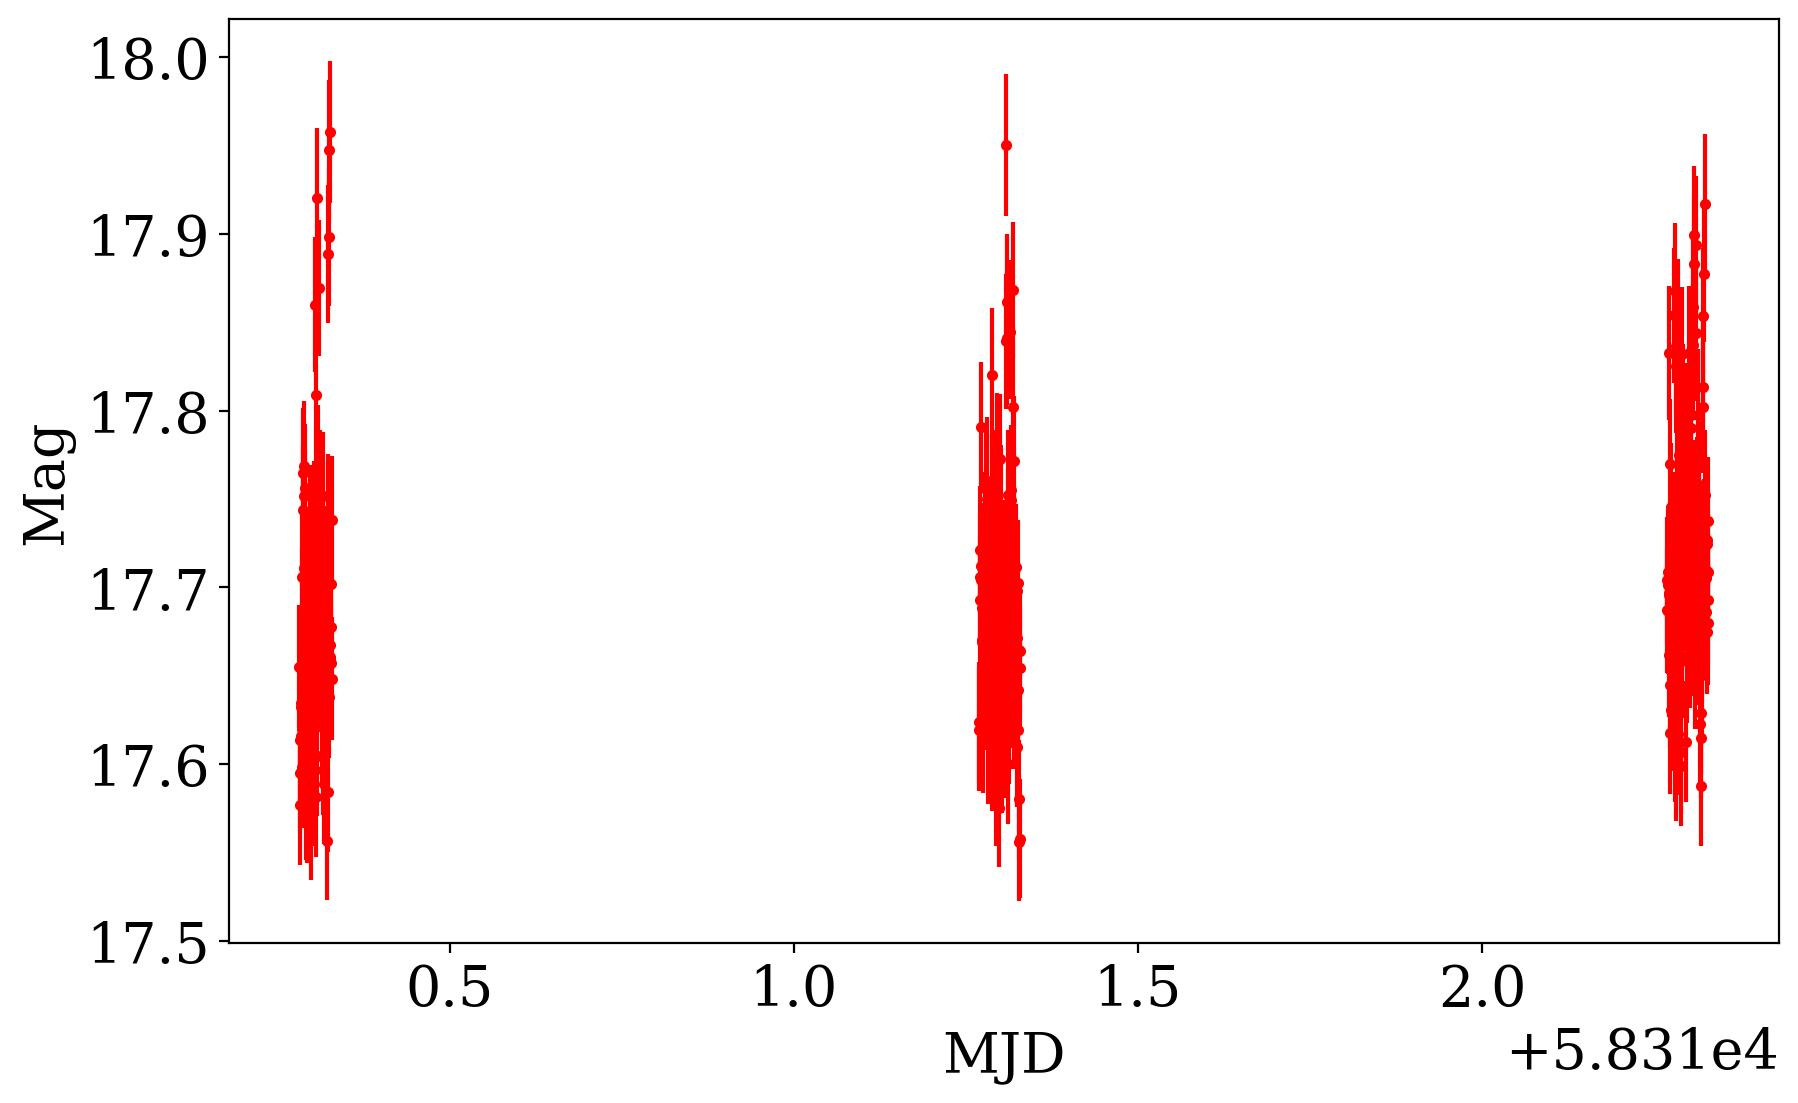

In [117]:
plot_hc_ts(ens, 8152498278085165056)

In [104]:
test_ts = ens.to_timeseries(8158317593615138816)

In [109]:
mask_test = ((test_ts.data.loc['g', 'catflags']==0) 
            & (test_ts.data.loc['g', 'magerr']>0)
            & (~np.isnan(test_ts.data.loc['g', 'mjd']))
            & (~np.isnan(test_ts.data.loc['g', 'mag']))
            & (~np.isnan(test_ts.data.loc['g', 'magerr'])))

In [111]:
test_srt = test_ts.data.loc['g', 'mjd'].argsort()

In [113]:
test_ts.data.loc['g'][mask_test]

,ps1_objid_object,ra_object,dec_object,ps1_gMeanPSFMag_object,ps1_rMeanPSFMag_object,ps1_iMeanPSFMag_object,nobs_g_object,nobs_r_object,nobs_i_object,mean_mag_g_object,...,Dir_object,Npix_object,ps1_objid,ra,dec,mjd,mag,magerr,band,catflags
index,,,,,,,,,,,,,,,,,,,,,
0,80392795050029758,279.50499,-23.00047,19.284,18.2223,17.809401,100,617,0,19.457035,...,0,7246,80392795050029758,279.50499,-23.00047,59349.42237,19.443317,0.102894,g,0
1,80392795050029758,279.50499,-23.00047,19.284,18.2223,17.809401,100,617,0,19.457035,...,0,7246,80392795050029758,279.50499,-23.00047,58676.31909,19.786068,0.124022,g,0
2,80392795050029758,279.50499,-23.00047,19.284,18.2223,17.809401,100,617,0,19.457035,...,0,7246,80392795050029758,279.50499,-23.00047,58673.31831,19.437563,0.102549,g,0
3,80392795050029758,279.50499,-23.00047,19.284,18.2223,17.809401,100,617,0,19.457035,...,0,7246,80392795050029758,279.50499,-23.00047,58667.34059,19.466795,0.104304,g,0
5,80392795050029758,279.50499,-23.00047,19.284,18.2223,17.809401,100,617,0,19.457035,...,0,7246,80392795050029758,279.50499,-23.00047,58246.46377,19.307051,0.094926,g,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,80392795050029758,279.50499,-23.00047,19.284,18.2223,17.809401,100,617,0,19.457035,...,0,7246,80392795050029758,279.50499,-23.00047,59462.17275,19.492901,0.105884,g,0
94,80392795050029758,279.50499,-23.00047,19.284,18.2223,17.809401,100,617,0,19.457035,...,0,7246,80392795050029758,279.50499,-23.00047,58282.38218,19.360466,0.098001,g,0
96,80392795050029758,279.50499,-23.00047,19.284,18.2223,17.809401,100,617,0,19.457035,...,0,7246,80392795050029758,279.50499,-23.00047,59469.15034,19.394154,0.099974,g,0


In [128]:
srt_mask_test = mask_test[test_srt]

In [129]:
mjd_test = test_ts.data.loc['g', 'mjd'][test_srt]
mag_test = test_ts.data.loc['g', 'mag'][test_srt]
magerr_test = test_ts.data.loc['g', 'magerr'][test_srt]

In [130]:
mjd_test_obs = mjd_test[srt_mask_test]
mag_test_obs = mag_test[srt_mask_test]
magerr_test_obs = magerr_test[srt_mask_test]

In [131]:
mjd_test

index
4     58229.50274
5     58246.46377
6     58273.44535
8     58279.36075
94    58282.38218
         ...     
86    59818.19476
90    59820.17285
87    59822.17318
88    59824.19375
89    59826.20541
Name: mjd, Length: 100, dtype: float64

In [132]:
obj_test_info = ens.object.loc[8158317593615138816].compute()

In [141]:
start_hc_test = obj_test_info.loc[8158317593615138816, 'range_high_cad_g'][0]

In [139]:
end_hc_test = obj_test_info.loc[8158317593615138816, 'range_high_cad_g'][1]

In [142]:
mask_hc_obs = (mjd_test <= end_hc_test) & (mjd_test >= start_hc_test)

In [144]:
np.sum(mask_hc_obs)

0